<a href="https://colab.research.google.com/github/frederik-kilpinen/ASDS2/blob/main/topic_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing erlevant packages 
import numpy as np
import pandas as pd
from datetime import datetime 
from tqdm import tqdm 
import logging 
import sys 
import pickle 
import requests
import io

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
#pip install nltk==3.4

In [2]:
#Importing and viewing data
tweets = pd.read_csv("/content/drive/MyDrive/Digital methods/final_tweet_df")

In [3]:
#Reusing and tweaking the function for preprocessing from last week to fit specifics of this dataset.
def preprocess(text):
    
    #Lowercasing words
    text = str(text)
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    my_punctuation = string.punctuation.replace('#','')
    my_punctuation = my_punctuation.replace('-','')
    
    text = text.translate(str.maketrans('', '', my_punctuation))
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[’“”—,!]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Tokenizing
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

def preprocess_lemma(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

def preprocess_stem(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)

In [4]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Lemmatizing tweets
tweets["text_lemmatized"] = tweets.full_text.apply(lambda x: preprocess_lemma(x))

# Stemming tweets
tweets["text_stemmed"] = tweets.full_text.apply(lambda x: preprocess_stem(x))

In [6]:
#Replacing nan values with empty strings
tweets.text_lemmatized = tweets.text_lemmatized.apply(lambda x: '' if str(x) == 'nan' else x)
tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)

In [7]:
#Aggregating tweet data by dates and party 
tweets_agg = tweets.groupby(['created_at', 'p.party'], as_index = False).agg({'full_text': ' '.join,
                                                                            'text_lemmatized': ' '.join,
                                                                            'text_stemmed': ' '.join})

In [8]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas()

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['unigrams'] = tweets_agg['text_stemmed'].progress_apply(lambda x: tokenizer.tokenize(x))

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 14369/14369 [00:10<00:00, 1407.48it/s]


In [9]:
#5 Create bigrams from the unigrams
tweets_agg["bigrams"] = tweets_agg["unigrams"].apply(lambda x: list(nltk.bigrams(x)))

#Custom function to join the tuples of bigrams by an underscore
def join_tups(lst):
    return ['_'.join(tup) for tup in lst]

tweets_agg["bigrams"] = tweets_agg["bigrams"].apply(lambda x: join_tups(x))

In [21]:
#Create a id2word dictionary
tweets_agg['tokens'] = tweets_agg['unigrams'] + tweets_agg['bigrams']

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)

#Creating a corpus object 
corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


# **Topic modelling**

In [22]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 20 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, passes = 10, iterations = 100) # should be changed to passes = 100, iterations = 1000

#Disabling logging
logging.disable(sys.maxsize)

In [23]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(15,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
coronaviru #auspol #polita #coronaviru subsidi covid_- #covidau #covid #auspol_#polita crisi

------ Topic 1 ------
new today great job fund #auspol announc busi … australia

------ Topic 2 ------
… support health australian help peopl new today australia work

------ Topic 3 ------
great … today labor day thank #auspol morn team campaign

------ Topic 4 ------
#tyfi region #ourveteran birthday happi work #ourpeopl serv #tyfi_#ourveteran #regionsmatt

------ Topic 5 ------
parliament women … today hous #auspol minist pm #qt violenc

------ Topic 6 ------
age care age_care … servic year day anzac australian forget

------ Topic 7 ------
… #auspol turnbul cut govern liber senat labor today energi

------ Topic 8 ------
… 👇 #auspol govern care year liber time today need

------ Topic 9 ------
trade aussi australia free nation super china bob say great

------ Topic 10 ------
… australia australian peopl get govern one - good need

------ Topic 11 ------
labor … plan 

In [24]:
#Creating a dataframe with tokens as columns and topics as rows 
beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.

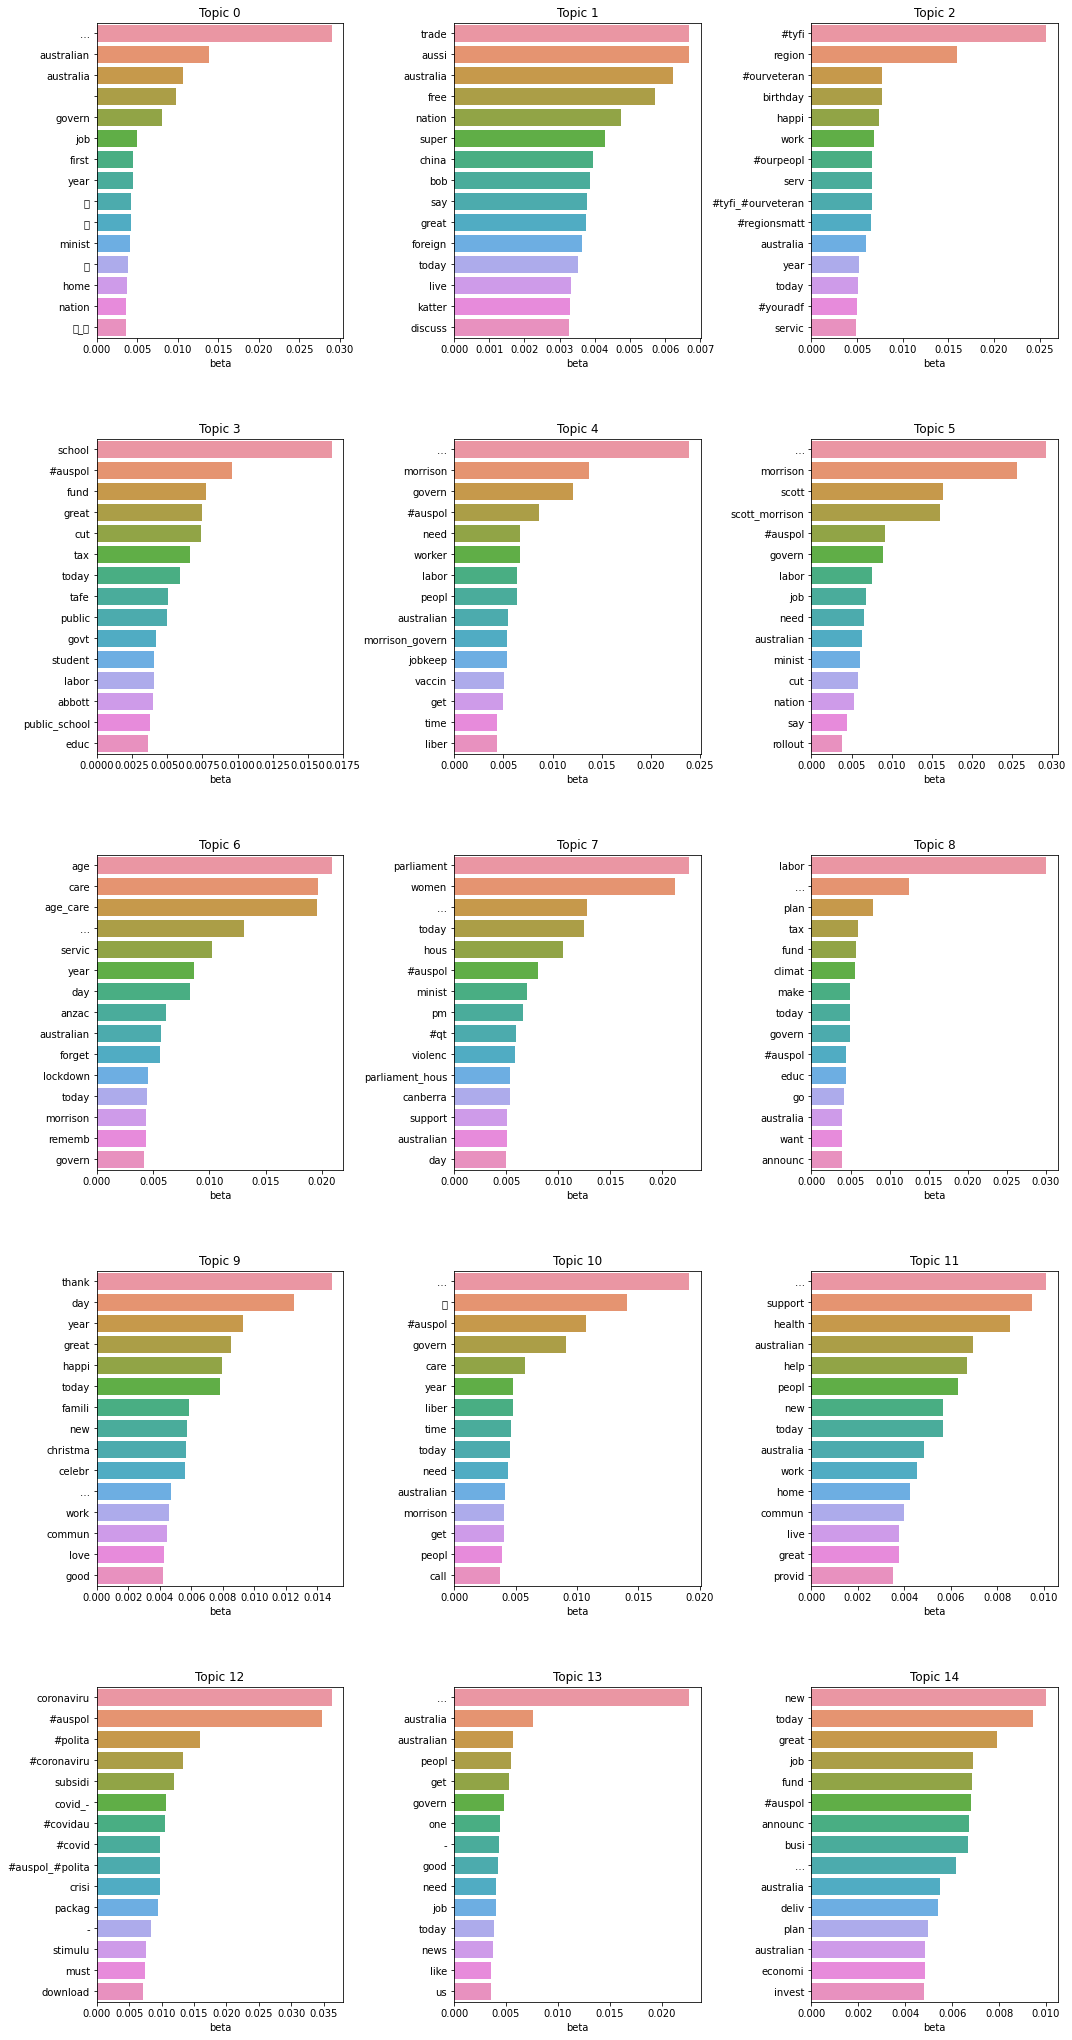

In [25]:
#Picking 15 topics to visualize
topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14]

fig, axes = plt.subplots(ncols=3, nrows=5, figsize = (16,30)) #Setting 15 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(15).values, 
                y = beta_df.iloc[topic].nlargest(15).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()

In [26]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(lda_model.get_document_topics(corpus)) 

#Creating a list of names for all 15 topics
topics = ['topic_{}'.format(t) for t in range(0,15)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),15)), columns = topics)

for i, doc in enumerate(document_topics): 
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]

In [27]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

In [28]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(15,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
#tyfi region #ourveteran birthday happi work #ourpeopl serv #tyfi_#ourveteran #regionsmatt

------ Topic 1 ------
… morrison scott scott_morrison #auspol govern labor job need australian

------ Topic 2 ------
… morrison govern #auspol need worker labor peopl australian morrison_govern

------ Topic 3 ------
school #auspol fund great cut tax today tafe public govt

------ Topic 4 ------
great … today labor day thank #auspol morn team campaign

------ Topic 5 ------
thank day year great happi today famili new christma celebr

------ Topic 6 ------
servic commun today thank great local day support help australian

------ Topic 7 ------
coronaviru #auspol #polita #coronaviru subsidi covid_- #covidau #covid #auspol_#polita crisi

------ Topic 8 ------
… 👇 #auspol govern care year liber time today need

------ Topic 9 ------
age care age_care … servic year day anzac australian forget

------ Topic 10 ------
… support health australian help peopl new today australia wor

In [29]:
# Date object
gamma_df["created_at"] = pd.to_datetime(gamma_df["created_at"])

In [30]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date', y = 'topic_3', hue = 'p.party', data = gamma_df)

plt.title('Topic of support over time (Topic 3)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('created_at')

plt.show()

ValueError: ignored

<Figure size 1008x576 with 0 Axes>